In [9]:
import csv, os
import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np

def can_convert_to_int(string):
    try:
        int(string)
        return True
    except ValueError:
        return False

def read_csv(filename, entries, d=1):
    stats, inds = {}, {}
    with open(filename, 'r') as file:
        csvreader = csv.reader((line.replace('\0','') for line in file))   
        max_rollout_depth_ind = -1
        for n, row in enumerate(csvreader):            
            if n == 0:
                for entry in entries:
                    if entry in row:
                        inds[entry] = row.index(entry)
                        stats[entry] = []
                continue          
            if len(row) > inds["step"] and can_convert_to_int(row[inds["step"]]) and int(row[inds["step"]]) > 10000:
                for entry in entries:
                    if entry in stats:
                        x = row[inds[entry]]
                        if entry == "total_norm":                                
                            x = x[x.find("(")+1:x.find(",")]
                        elif entry == "step":
                            x = int(x)/d
                        else:
                            x = float(x) if x else np.nan
                        stats[entry].append(x)
    return stats

def read_checkpoint(dir, run, d=1):    
    filename = os.path.join(dir, run, "logs.csv")
    if os.path.exists(filename):        
        entries = ["step", "real_step", "total_norm", "total_loss", "max_rollout_depth", "rmean_episode_return", "rmean_im_episode_return", "mean_plan_step"]
        stats = read_csv(filename, entries, d)
    else:
        stats = None    

    filename = os.path.join(dir, run, "logs_model.csv")
    if os.path.exists(filename):        
        entries = ["step", "real_step", "model_returns_mean", "model_returns_std", "vs_loss", "logits_loss"]
        stats_model = read_csv(filename, entries, d)
    else:
        stats_model = None    
    assert stats is not None or stats_model is not None, "Cannot read csvs from folder %s" % os.path.join(dir, run)
    return [stats_model, stats]

def simplify(stats_list, gap=100000):        
    new_stats = {}
    for stats in stats_list:
        if stats is not None and ("real_step" in stats or "step" in stats):
            ind = 0
            for k in stats.keys(): new_stats[k] = []
            r_step = stats["real_step"] if "real_step" in stats.keys() else stats["step"]
            for n, step in enumerate(r_step):
                if step > ind:
                    for k in stats.keys():
                        new_stats[k].append(stats[k][n])
                    ind += gap

    return new_stats
    
def mv(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

def plot(all_stats, y="rmean_episode_return", plot_dict=None, baseline=0, mv_avg=20, xlim=int(1e8), style=None, figsize=(24,8)):   
    plt.style.use("default" if style is None else style)    
    rotate_n = 10 if style is None else 6    
    if plot_dict is None: plot_dict = {k:k for k in all_stats.keys()}           
    linestyles=["solid", "dashed", "dotted","dashdot"]
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    if baseline == 1:
        ax.axhline(y=0.12, color='r', label="base policy", linewidth=1)
        ax.axhline(y=1.08, color='g', label="1-step exhaustive search", linewidth=1)
        ax.axhline(y=1.17, color='y', label="2-step exhaustive search", linewidth=1)
        ax.axhline(y=1.59, color='b', label="2-step 15-rollout search", linewidth=1)
        ax.axhline(y=1.50, color='c', label="20-simulations MCTS", linewidth=1)
    elif baseline == 2:
        ax.axhline(y=0.12, color='r', label="base policy", linewidth=1)
        ax.axhline(y=1.08, color='grey', label="1-step exhaustive search (5 steps)", linewidth=1)
        ax.axhline(y=1.81, color='darkgreen', label="2-step exhaustive search (30 steps)", linewidth=1)
        ax.axhline(y=2.14, color='navy', label="70-simulations MCTS (70 steps)", linewidth=1)        
        ax.axhline(y=2.31, color='purple', label="3-step exhaustive search  (155 steps)", linewidth=1)
        ax.axhline(y=2.66, color='plum', label="8-step 20-rollout search (160 steps)", linewidth=1)            
        ax.axhline(y=2.96, color='gold', label="4-step exhaustive search  (780 steps)", linewidth=1)
        ax.axhline(y=3.34, color='white', label="5-step exhaustive search  (3905 steps)", linewidth=1)         
    
    n = 0    
    for run, label in plot_dict.items():
        xs = all_stats[run]["real_step"] if "real_step" in all_stats[run] else all_stats[run]["step"]        
        if y not in all_stats[run]: continue
        ys = all_stats[run][y]
        if len(xs) != len(ys):
            xs = xs[:min(len(xs), len(ys))]
            ys = ys[:min(len(xs), len(ys))]
        if mv_avg > len(xs): continue
        bound = np.nonzero(np.array(xs) > xlim)[0]
        if len(bound) >= 1:
            xs = xs[:bound[0]]
            ys = ys[:bound[0]]
        ax.plot(np.array(xs[mv_avg-1:]), 
                mv(ys, n=mv_avg), 
                label=label, 
                linestyle=linestyles[(n//rotate_n)%4],
                linewidth=1)
        n += 1
        
    plt.xlim(0, xlim)    
    plt.xlabel("step")
    ylabels = {"rmean_im_episode_return" : "planning returns",
               "rmean_episode_return": "real returns",
               "max_rollout_depth": "max search depth",
               "mean_plan_step": "planning steps"}
    
    plt.ylabel(ylabels[y] if y in ylabels.keys() else y)

    #plt.tight_layout() 
    plt.legend()
    if style == "cyberpunk": 
        pass
        #mplcyberpunk.make_lines_glow()
    if style is None:
        plt.grid()
    plt.show()   
    
def download(dir, latest_runs=None, refresh=True, load=True, load_runs=None):    
    if refresh:
        assert latest_runs is not None, "need to specify runs to download"
        for server, lr in latest_runs.items():
            path = os.path.join(dir, lr)
            cdir = "thinker"          
            if os.name == "nt":
                path = os.path.join(dir, lr)                
                !md $path
                !scp $server:~/RS/thinker/logs/$cdir/latest/*.* $path
            else:                
                !mkdir $dir/$lr
                !scp $server:~/RS/thinker/logs/$cdir/latest/*.* $dir/$lr        
    if load: 
        all_stats = load_dir(dir, runs=load_runs)
        add_plan_step(all_stats)
        return all_stats
    
def load_dir(dir, runs=None):
    if runs is None:   runs = os.listdir(dir)
    all_stats = {}
    mv_avg = 20
    for run in runs:
        if "past" == run: continue
        if "rei" in run and "flex" not in run:
            st = run.find("rec_n_")
            d = int(run[st+6:run.find("_", st+6)])
        else:
            d = 1  
        stats = simplify(read_checkpoint(dir, run, d))
        all_stats[run] = stats
    return all_stats    

def add_plan_step(stats):
    for k, v in stats.items():
        if 'real_step' in v.keys():
            r = np.array(v['real_step'])
            t = np.array(v['step'])
            d = (t[1:] - t[:-1]) / (r[1:] - r[:-1])
            v['mean_plan_step'] = np.concatenate([[0.], d])

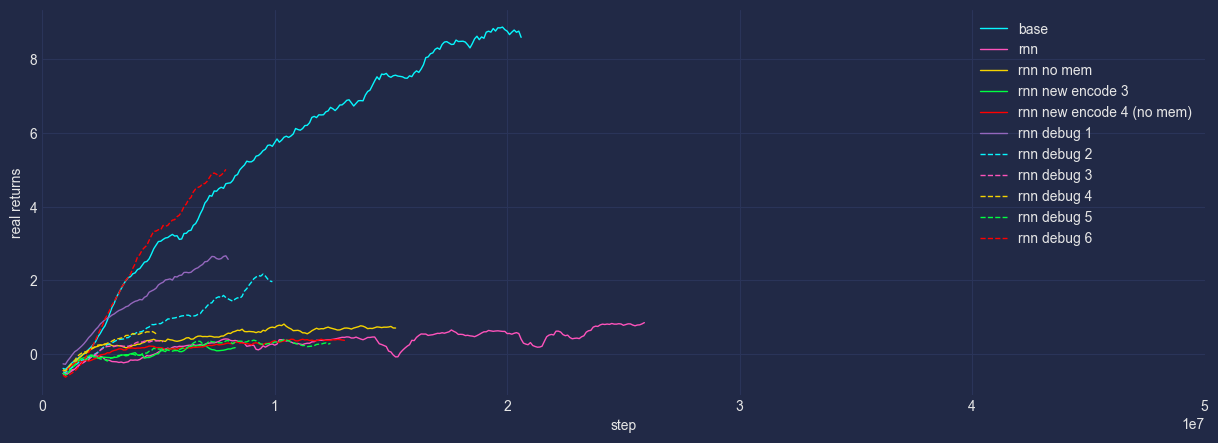

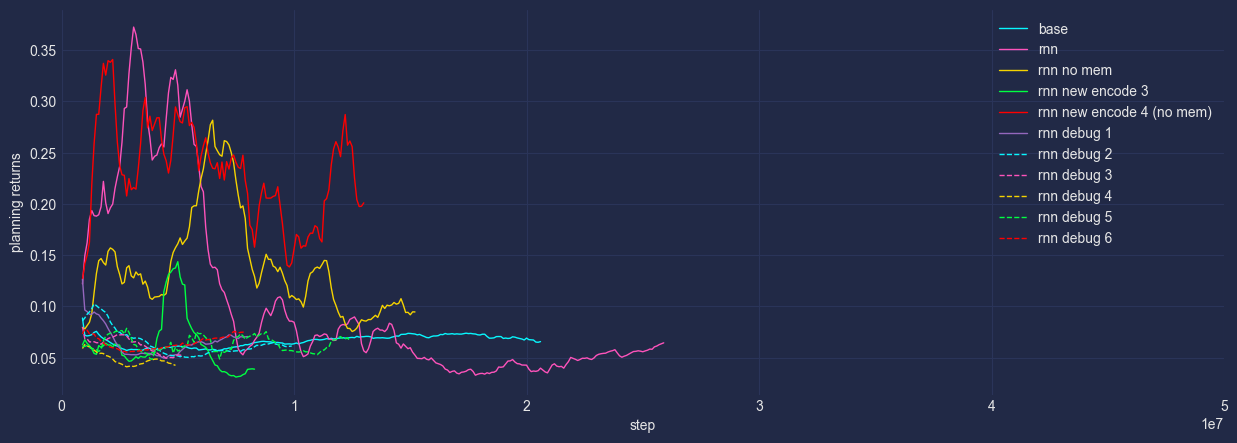

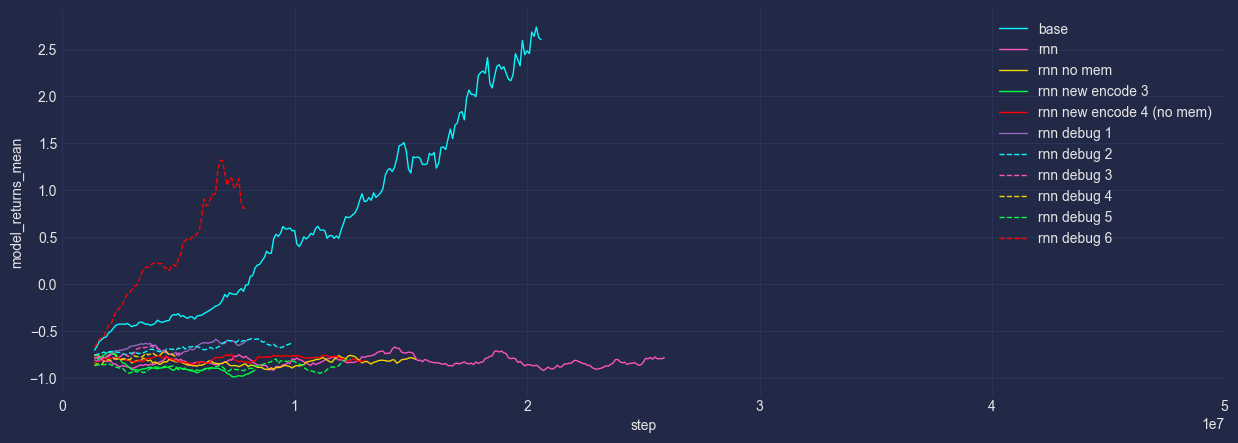

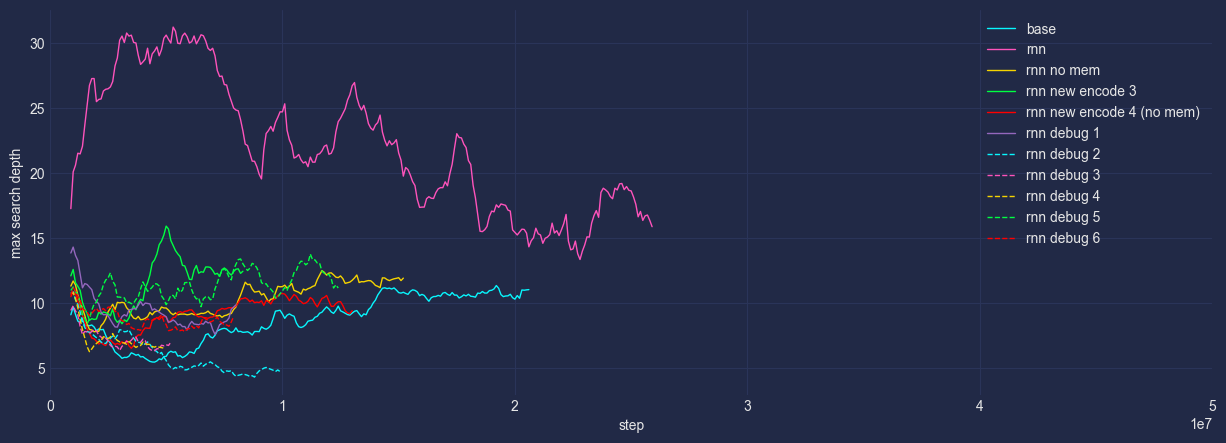

In [20]:
%matplotlib inline
#%matplotlib qt

dir = "/media/sc/datadisk/data/thinker/logs/planner_logs"
if not os.path.exists(dir):
   dir = "D:\\data\\thinker\\logs\\planner_logs"

latest_runs = {#"uk": "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_threscarry",                   
               "cam": "thinker_model_rnn_0.1lr_newencode_4",
               "v3": "thinker_model_0.5policycost_threscarry",
               "v5": "thinker_model_rnn_debug6", 
               "v6": "thinker_model_0.5policycost_20rec_t_nopreload", 
            }       

type_plot = 0

if type_plot == 1:

   plot_dict = {    
      #"alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "no model",
      "thinker_model_0.5policycost":"base",
      "thinker_model_no_preload":"base - no preload",   
      "thinker_model_0.5policycost_20rec_t": "base 20 rec_t",
      "thinker_model_0.5policycost_20rec_t_nopreload": "base 20 rec_t no preload",
      "thinker_model_0.5policycost_threscarry": "base threscarry",
   }

else:

   plot_dict = {  
      "thinker_model_0.5policycost_20rec_t_nopreload": "base",
      "thinker_model_rnn_0.1lr":"rnn",      
      "thinker_model_rnn_0.1lr_no_mem": "rnn no mem",
      "thinker_model_rnn_0.1lr_newencode_3": "rnn new encode 3",
      "thinker_model_rnn_0.1lr_newencode_4": "rnn new encode 4 (no mem)",
      "thinker_model_rnn_debug": "rnn debug 1",
      "thinker_model_rnn_debug2": "rnn debug 2",      
      "thinker_model_rnn_debug3": "rnn debug 3",  
      "thinker_model_rnn_debug4": "rnn debug 4",  
      "thinker_model_rnn_debug5": "rnn debug 5",  # model_rnn, batch_mode
      "thinker_model_rnn_debug6": "rnn debug 6",  # no model_rnn, batch_mode
   }

#for k, v in latest_runs.items():
#   if v not in plot_dict: plot_dict[v] = v

#style = None
style = "cyberpunk"
figsize = (15, 5)

#download(dir, latest_runs, refresh=True, load=False, load_runs=None)
all_stats = download(dir, latest_runs=None, refresh=False, load=True, load_runs=plot_dict.keys())

plot(all_stats, "rmean_episode_return", plot_dict, mv_avg=10, baseline=0, xlim=int(5e7), style=style, figsize=figsize)
plot(all_stats, "rmean_im_episode_return", plot_dict, baseline=0, mv_avg=10, xlim=int(5e7), style=style, figsize=figsize)
plot(all_stats, "model_returns_mean", plot_dict, baseline=0, mv_avg=10, xlim=int(5e7), style=style, figsize=figsize)
plot(all_stats, "max_rollout_depth", plot_dict, baseline=0, mv_avg=10, xlim=int(5e7), style=style, figsize=figsize)
#plot(all_stats, "mean_plan_step", plot_dict, baseline=0, mv_avg=10, xlim=int(5e7), style=style, figsize=figsize)

In [19]:
all_stats["thinker_model_rnn_debug5"]

{'step': [12800.0],
 'real_step': [640.0],
 'total_norm': ['613.9358'],
 'total_loss': [-778.2222900390625],
 'max_rollout_depth': [5.05625],
 'rmean_episode_return': [0.0],
 'rmean_im_episode_return': [0.22960798],
 'mean_plan_step': array([0.])}

mkdir: cannot create directory ‘/media/sc/datadisk/data/thinker/logs/model_logs/model_base_pri’: File exists
ckp_model.tar                                 100%   15MB  14.7MB/s   00:01    
fields_model.csv                              100%    0     0.0KB/s   00:00    
logs_model.csv                                100% 2804KB  14.5MB/s   00:00    
meta_model.json                               100% 5883   175.3KB/s   00:00    
out_model.log                                 100%  353    15.3KB/s   00:00    


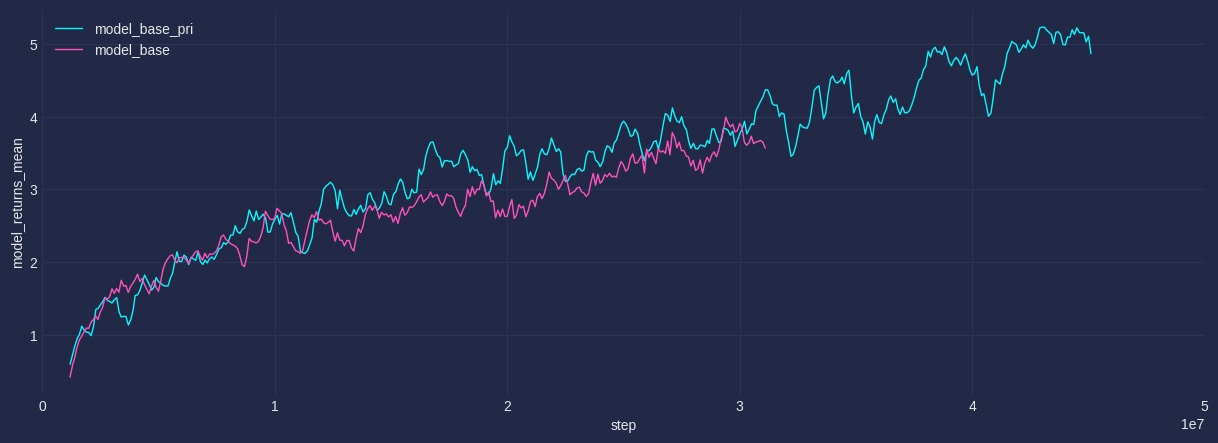

In [4]:
%matplotlib inline
#%matplotlib qt

dir = "/media/sc/datadisk/data/thinker/logs/model_logs"
if not os.path.exists(dir):
   dir = "D:\\data\\thinker\\logs\\model_logs"

latest_runs = {"cam": "model_base_pri",
               #"v5": "model_base", 
            }       

plot_dict = {"model_base_pri":"model_base_pri",
             "model_base": "model_base"}

for k, v in latest_runs.items():
   if v not in plot_dict: plot_dict[v] = v

#style = None
style = "cyberpunk"
figsize = (15, 5)

download(dir, latest_runs, refresh=True, load=False, load_runs=None)
all_stats = download(dir, latest_runs=None, refresh=False, load=True, load_runs=plot_dict.keys())
plot(all_stats, "model_returns_mean", plot_dict, baseline=0, mv_avg=10, xlim=int(5e7), style=style, figsize=figsize)

In [ ]:
# policy improvement step
plot_dict = {    
   "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "no model",
   #"thinker_model_0.1lr": "0.1lr",
   #"thinker_model_no_pri": "no_pri",
   #"thinker_model": "base",
   #"thinker_model_0.01policycost":"0.01policycost",   
   #"thinker_model_no_preload":"no preload",
   #"thinker_model_1m_buffer": "1m buffer",
   "thinker_model_0.5policycost":"0.5policycost",
   "thinker_model_0.5policycost_20rec_t": "0.5policycost 20rec_t",
   "thinker_model_0.5policycost_threscarry": "0.5policycost thres_carry",
}

# flexible planning 
plot_dict = {   
   "new_no_thres_carry": "39 fixed planning steps",
   "new_flex_t_1e-3_no_thres_carry": "flex_t=1e-3",
}

# flexible planning full
plot_dict = {  
   #"new_flex_t_1e-4": "flex_t_1e-4",
   #"new_flex_t_2e-4": "flex_t_2e-4",     
   #"new_flex_t_5e-4": "flex_t_5e-4", 
   "new_flex_t_1e-3_no_thres_carry": "flex_t_1e-3 no_thres_carry",  
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "10 steps",
   #"alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "20 steps",   
   "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "base",
   "new": "new",
   "thinker_new": "thinker_new",
   "new_no_ent": "new_no_ent",  
   "new_large_ent": "new_large_ent",  
   "new_no_thres_carry": "new_no_thres_carry",
   #"new_100_rollout": "new_100_rollout",
}

plot_dict = {  
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "10 steps",
   "alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "20 steps",   
   "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "40 steps",
   "debug_new_flex_t_1e-4": "debug_new_flex_t_1e-4",
   "debug_new_flex_t_2e-4": "debug_new_flex_t_2e-4",     
   "debug_new_flex_t_5e-4": "debug_new_flex_t_5e-4"    
}

plot_dict = {  
   
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "10 steps",
   "alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "20 steps",   
   "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "40 steps",
   "alstm_3_1_flext_5e-5": "flext 5e-5", 
   "alstm_3_1_flext_1e-4": "flext 1e-4",  
   "alstm_3_1_flext_1e-4_pos_2": "flext 1e-4 new",
   "alstm_3_1_flext_5e-4": "flext 5e-4",     
   "alstm_3_1_flext_5e-3-0.01": "flext_5e-3-0.01",
   "alstm_3_1_rec_n_40_pos": "40 steps new",
   #"alstm_3_1_flext_1e-4_pos": "flext 1e-4 new",      
    
}

plot_dict = {
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem0_imcost_0_perfect": "imcost_0_mem_0",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0_perfect": "imcost_0",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect": "imcost_0.5",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect": "imcost_1",   
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.25_perfect_largeclip": "imcost_0.25, largeclip",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect_resetm_1_largeclip": "imcost_0.5, largeclip, resetm_1",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect_resetm_1_nograd": "imcost_0.5, nograd, resetm_1, nograd",
   #"alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_0.1_perfect": "imcost_0.1 (40 steps)", 
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0_perfect_treecarry": "imcost_0 tree_carry",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry": "imcost_1 tree_carry",    
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "imcost_1 tree_carry off_policy_RR_carry",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_threscarry" : "off-policy RR carry",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_resetm_3": "imcost_1 resetm_3 ttcarry",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem2.5_imcost_1_perfect_treecarry_threscarry": "imcost_1 mem_2.5 ttcarry",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem2_imcost_1_perfect_treecarry_threscarry_nograd": "nograd ttcarry", 
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_rewardcarry": "ttrcarry",       
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_2_perfect_treecarry_threscarry": "imcost_2 ttcarry",    
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_tree_vb_-0.5": "vb -0.5", 
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_tree_vb_+0.5": "vb +0.5", 
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_tree_vb_-0.5": "ttcarry vb-0.5",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_tree_vb_+0.5": "ttcarry vb+0.5",   
   #"alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_0.25_perfect": "imcost_0.25 (20 steps)",
   #"alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_0.5_perfect": "imcost_0.5 (20 steps)",        
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "10 steps",
   "alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "20 steps",   
   "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "40 steps",
   "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_0.5_perfect_treecarry_threscarry" : "40 steps 2",
   "alstm_3_1_rec_n_60_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "60 steps", 
   #"alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_0_perfect": "19 steps im_cost 0",   
   "alstm_3_1_flext_1e-9": "flext_1e-9",
}

plot_dict = {  
   
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "9 steps",
   "alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "19 steps",   
   "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "39 steps",
   #"alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_0_perfect": "19 steps im_cost 0",    
}

plot_dict = {"lstm_3_1_rec_n_5_w": "Backprop",
             "lstm_3_1_rec_n_5_gbste": "GB-STE",
             "lstm_3_1_rec_n_5_ste": "STE",
              "lstm_3_1_rec_n_5_rei": "REINFORCE",        
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"lstm_3_1_rec_n_5_gbste": "GB-STE",
             "lstm_3_1_rec_n_5_gbste_aug": "GB-STE w/ augmented stat.",
             "lstm_3_1_rec_n_5_rei": "REINFORCE",        
             "lstm_3_1_rec_n_5_rei_aug": "REINFORCE w/ augmented stat.",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"lstm_3_1_rec_n_5_gbste": "LSTM",
             "tran_3_1_rec_n_5_gbste_aug": "Transformer",        
             "alstm_3_1_rec_n_5_gbste_aug": "LSTM w/ attn. (4 steps)",
             "alstm_3_1_rec_n_10_gbste_aug": "LSTM w/ attn. (9 steps)",          
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"lstm_3_1_rec_n_5_gbste": "LSTM_3_1",
             "tran_3_1_rec_n_5_gbste_aug": "Transformer",        
             "alstm_3_1_rec_n_5_gbste_aug": "ALSTM_3_1 (4 steps)",
             "alstm_3_1_rec_n_10_gbste_aug": "ALSTM_3_1 (9 steps)",             
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps; clipped)",             
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps; clipped)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"alstm_3_1_rec_n_1_gbste_aug_clip": "ALSTM_3_1 (0 steps; clipped)",             
             "alstm_3_1_rec_n_2_gbste_aug_clip": "ALSTM_3_1 (1 steps; clipped)",                     
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps; clipped)",             
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps; clipped)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"alstm_3_1_rec_n_1_gbste_aug_clip": "ALSTM_3_1 (0 steps)",                  
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps)",                          
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps)",    
             "alstm_3_1_rec_n_1_gbste_aug_clip_realnomem": "ALSTM_3_1 (0 steps; no mem.)",                  
             "alstm_3_1_rec_n_5_gbste_aug_clip_realnomem": "ALSTM_3_1 (4 steps; no mem.)",                          
             "alstm_3_1_rec_n_10_gbste_aug_clip_realnomem": "ALSTM_3_1 (9 steps; no mem.)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {
             "alstm_3_1_rec_n_1_gbste_aug_clip": "ALSTM_3_1 (0 steps; clipped)",
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps; clipped)",             
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps; clipped)",
             "alstm_3_1_rec_n_1_gbste_aug_clip_realnomem": "ALSTM_3_1 (0 steps; clipped; real_no_mem)",
             "alstm_3_1_rec_n_5_gbste_aug_clip_realnomem": "ALSTM_3_1 (4 steps; clipped; real_no_mem)",
             "alstm_3_1_rec_n_10_gbste_aug_clip_realnomem": "ALSTM_3_1 (9 steps; clipped; real_no_mem)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {#"alstm_3_1_rec_n_1_rei_aug_clip_realnomem": "ALSTM_3_1 (0 steps; clipped; real_no_mem)",
             "alstm_3_1_rec_n_5_rei_aug_clip_realnomem": "4 steps; REINFORCE",
             "alstm_3_1_rec_n_10_rei_aug_clip_realnomem": "9 steps; REINFORCE", 
             #"alstm_3_1_rec_n_1_gbste_aug_clip_realnomem": "ALSTM_3_1 (0 steps; no mem.)",                  
             "alstm_3_1_rec_n_5_gbste_aug_clip_realnomem": "4 steps; GB-STE",                          
             "alstm_3_1_rec_n_10_gbste_aug_clip_realnomem": "9 steps; GB-STE",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"alstm_3_1_rec_n_10_rei_clip_realnomem": "Stat type 1", 
             "alstm_3_1_rec_n_10_rei_aug_clip_realnomem": "Stat type 2", 
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem0": "Stat type 3", 
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0": "Stat type 3 (with real mem)",  
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(5e7))

plot_dict = {
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem0": "Stat type 3", 
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0": "Stat type 3 (with real mem)",  
            }
plot(all_stats, "max_rollout_depth", plot_dict, mv_avg=20, xlim=int(5e7))

plot_dict = {
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0": "im_cost=0",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5": "im_cost=0.5",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1": "im_cost=1",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0_perfect": "im_cost=0 (perfect)",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect": "im_cost=0.5 (perfect)",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect": "im_cost=1 (perfect)",    
   
}

plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(5e7))
plot(all_stats, "max_rollout_depth", plot_dict, mv_avg=20, xlim=int(5e7))